In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx
from networkx import DiGraph

### Generating Data


In [2]:
class DataGenerator():
    def __init__(self, n_stages=6,  n_ways=4, n_users=10, size=100):
        self.df = None      
        self.n_stages = n_stages
        self.n_ways = n_ways
        self.n_users = n_users
        self.size = size
    
    def make_df(self):
        df_len = self.n_ways * self.size
        data = pd.DataFrame(np.arange(df_len), columns=['id'])
        data['stages'] = [0] * df_len
        data['user'] = np.random.randint(0, self.n_users, df_len)
        ways = []
       

        # creating random ways
        while len(ways) != self.n_ways:
            way = [1] # start
            way_len = np.random.randint(2, self.n_stages)
            for _ in range(way_len):
                stage = np.random.randint(2, self.n_stages)
                way.append(stage)
            way.append(self.n_stages)
            way = pd.unique(way).tolist()
            if way not in ways and len(way) > 2:
                ways.append(way)                
        ways = np.repeat(ways, self.size)
        data['stages'] = ways            
        self.df = data
        return self    
    
    def expand(self):
        data = self.df
        data = data.explode('stages')
        data['stages'] = data['stages'].astype(str)
        data['from'] = data.groupby(['id'])['stages'].shift(1)       
        self.df = data
        return data        

In [3]:
G = DataGenerator()
G.make_df()
G.df.head()

,id,stages,user
0,0,"[1, 5, 2, 6]",3
1,1,"[1, 5, 2, 6]",7
2,2,"[1, 5, 2, 6]",0
3,3,"[1, 5, 2, 6]",7
4,4,"[1, 5, 2, 6]",1


In [4]:
data = G.expand()
data.head()

,id,stages,user,from
0,0,1,3,NaN
0,0,5,3,1
0,0,2,3,5
0,0,6,3,2
1,1,1,7,NaN


### implementing Graph class

In [8]:
class Graph():
    def __init__(self, df, id_col, stage_col):
        self.df = df
        self.id_col = id_col
        self.stage_col = stage_col
        self.stages = np.unique(self.df[stage_col])
        self.graph = None
        
    def create_activities_graph(self):
        stages = self.df[self.stage_col].unique()
        graph = DiGraph() 
        for stage in stages:
            graph.add_node(str(stage))
        self.df['from'] = self.df.groupby([self.id_col])[self.stage_col].shift(1)
        edges = self.df.loc[:, ['from', self.stage_col]].drop_duplicates().dropna().values
        edges = [list(map(str, edge)) for edge in edges]
        graph.add_edges_from(edges)
        self.graph = graph
        return graph

    
    def draw_activities(self):

        activity_matrix = np.zeros((len(self.stages)+1, len(self.stages)+1))
        
        for _, row in self.df.iterrows():
            if(pd.isna(row['from'])):
                continue
                
            x_from = int(row['from'])
            x_stag = int(row['stages'])
            activity_matrix[x_from, x_stag] += 1

        self.activity_matrix = activity_matrix
        
        graph = DiGraph()
        graph.add_nodes_from(self.graph.nodes)
        
        plt.figure(figsize=(16, 8))
        plt.title("Граф перехода активностей")
        for edge in self.graph.edges:
            graph.add_edge(edge[0], edge[1], weight=0.7 + 0.03*activity_matrix[int(edge[0]), int(edge[1])])
            
        weights = [graph[u][v]['weight'] for u,v in graph.edges]
        nx.draw(graph, width=weights, with_labels=True, font_size=20, node_size=1000, node_color='c')
        plt.show()
        
    def draw_users(self):

        self.users = np.unique(self.df['user'])
        users_matrix = np.zeros((len(self.users), len(self.users)))
        
        for stage in self.stages:
            df = data.loc[data.stages == stage]
            
            users = df.user.values
            for i in range(1, len(users)):
                user = users[i]
                prev = users[i-1]
                users_matrix[user, prev] += 1
                
        self.users_matrix = users_matrix
        
        graph = nx.Graph()
        graph.add_nodes_from(self.users)
        
        plt.figure(figsize=(16, 8))
        plt.title("Граф социальных связей")
        
        for i in range(len(self.users)):
            for j in range(i, len(self.users)):
                width = users_matrix[i, j] + users_matrix[j, i]

                if width > 0:
                    graph.add_edge(self.users[i], self.users[j] , weight=0.05*width)

        weights = [graph[u][v]['weight'] for u,v in graph.edges]
        nx.draw(graph, width=weights, with_labels=True, font_size=20, node_size=1000, node_color='c')
        plt.show()       

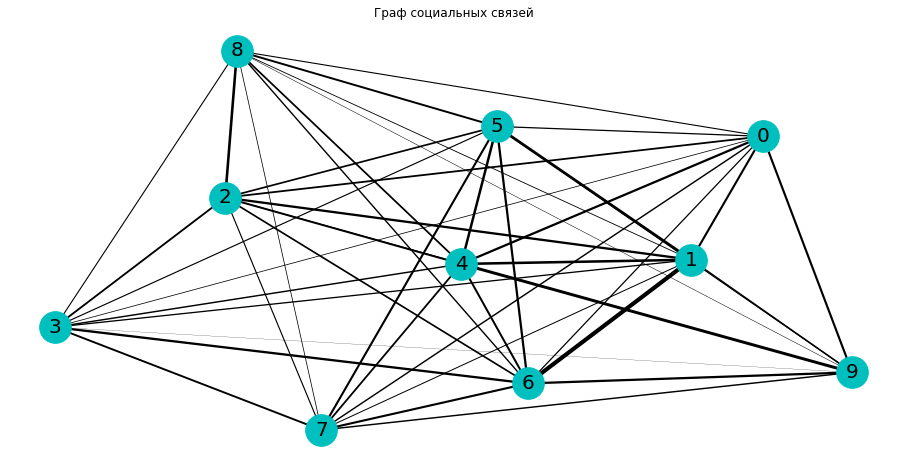

In [9]:
graph = Graph(data, 'id', 'stages')
graph.draw_users()

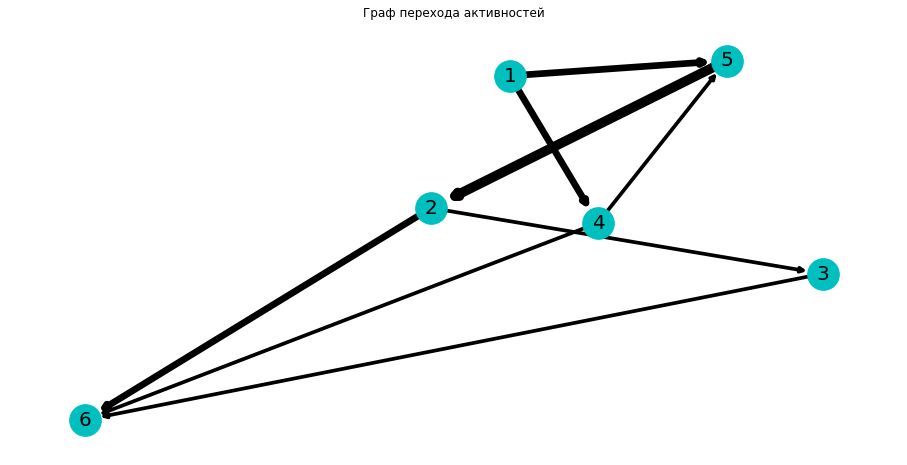

In [10]:
graph = Graph(data, 'id', 'stages')
graph.create_activities_graph()
graph.draw_activities()